План работы такой:
1) Победить интерфейс и выкачать с каждой базы данных в формате fasta
2) Унифицировать формат данных
3) Установть трешхолд похожести и непохожести данных 
4) Продумать алгоритм сортировки

заметки: 
почему-то у RNAcentral указан только ген и имя микроРНК, но нет SCORE

Тогда наверное буду сперва сортировать по вхождениям, и потом уже из этого - по score


ещё надо будет в виде диаграмм построить

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML
%matplotlib notebook
plt.rcParams["image.cmap"] = "gray"
plt.rcParams["image.interpolation"] = "none"

In [6]:
#покажу тут что получается при скачивании 
# этих баз данных
GenCardsI = plt.imread('GenCards.jpg')
mirbaseI = plt.imread('mirbase.jpg')
miRDBI = plt.imread('miRDB.jpg')
hgncI = plt.imread('hgnc.jpg')
NCBII = plt.imread('NCBI.png')

<IPython.core.display.Javascript object>


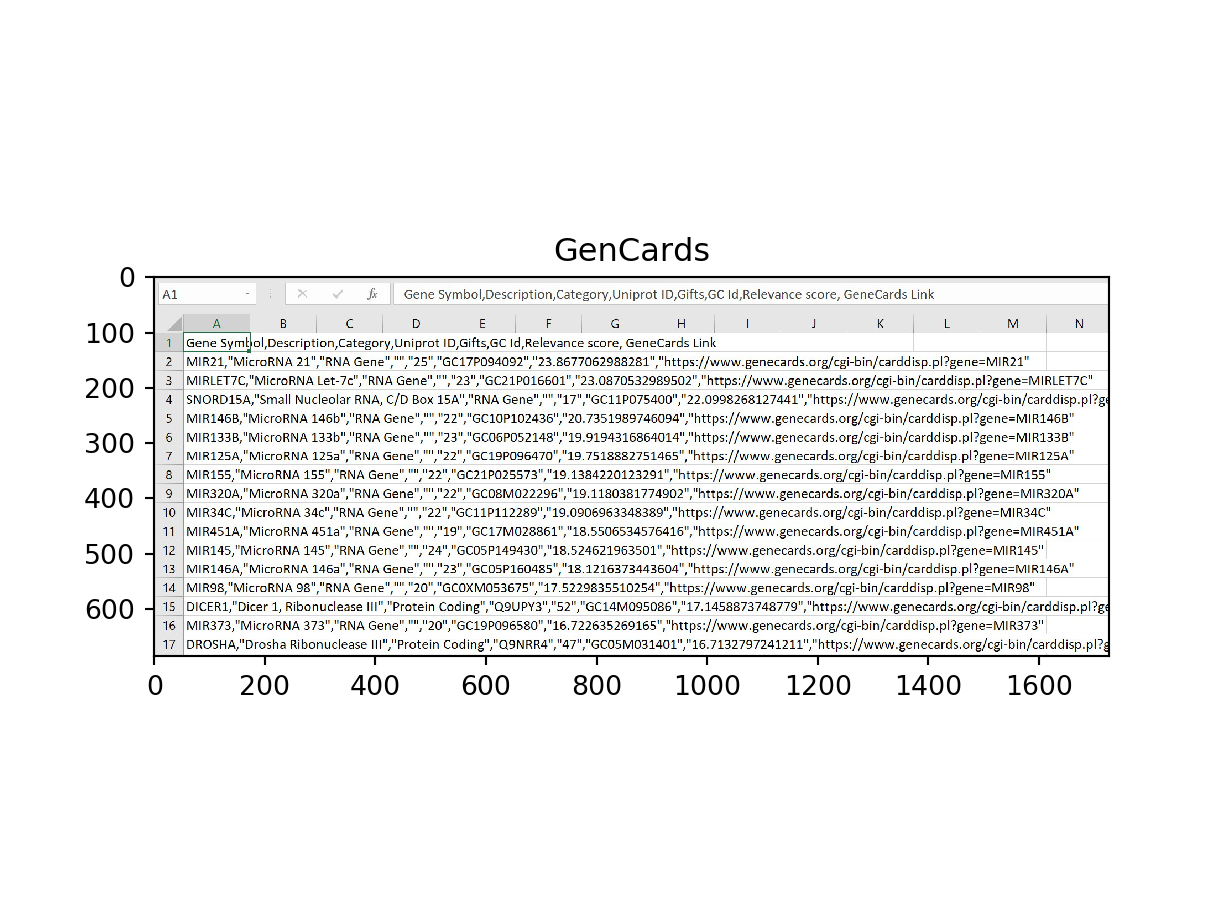

Text(0.5, 1.0, 'GenCards')

In [7]:
#иллюстрации тут приведу, чтобы потом таскать в презентацию
plt.figure()
plt.imshow(GenCardsI)
plt.title('GenCards')

Text(0.5, 1.0, 'mirbase')

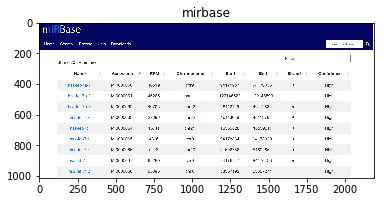

In [4]:
plt.figure()
plt.imshow(mirbaseI)
plt.title('mirbase')


<IPython.core.display.Javascript object>


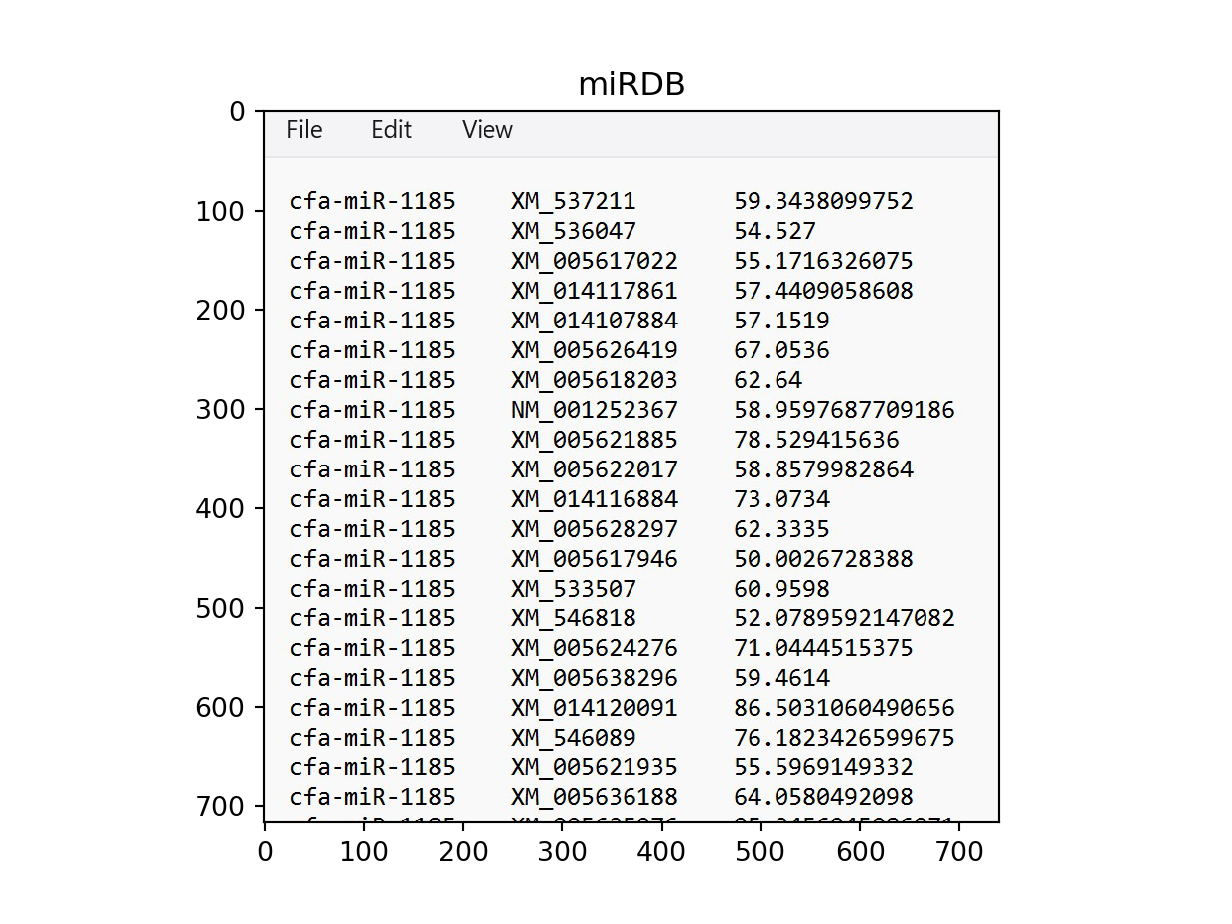

Text(0.5, 1.0, 'miRDB')

In [99]:
plt.figure()
plt.imshow(miRDBI)
plt.title('miRDB')

Text(0.5, 1.0, 'hgnc')

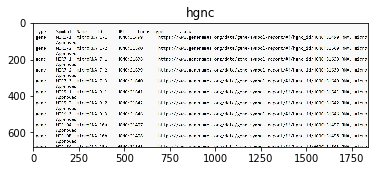

In [6]:
plt.imshow(hgncI)
plt.title('hgnc')

In [9]:
#На данный момент форматирование данных очень разное везде, и перед анализом надо
# привести их к общему виду
# ниже приведу рефференсы как это выглядит сейчас


In [10]:
# Список файлов
files = ['miRDB_v6.txt', 'hgnc.txt', 'mirbase_org.txt', 'miRNA.fasta', 'GeneCards.csv']
for file in files:
    df = pd.read_csv(file, nrows=2, sep='\t') if file.endswith('.txt') else pd.read_csv(file, nrows=2)
    display(HTML(f"<b>База:</b> {file}"))
    display(df)
    print("\n" + "="*2 + "\n")  

,cfa-miR-1185,XM_537211,59.3438099752
0,cfa-miR-1185,XM_536047,54.527000
1,cfa-miR-1185,XM_005617022,55.171633



==



,Type,Symbol,Name,ID,URL,Locus type,status
0,gene,MIR1-1,microRNA 1-1,HGNC:31499,https://www.genenames.org/data/gene-symbol-rep...,"RNA, micro",Approved
1,gene,MIR1-2,microRNA 1-2,HGNC:31500,https://www.genenames.org/data/gene-symbol-rep...,"RNA, micro",Approved



==



,Name,Accession,RPM,Chrmsm,Start,End,Strand Confidence
hsa-let-7a-1,MI0000060,46519,chr9,94175957,94176036,+,High
hsa-let-7a-2,MI0000061,46265,chr11,122146522,122146593,-,High



==



,>URS00000001C5_3760 Prunus persica (peach) microRNA miRNA_416
0,TTAGGTTTCCTCTTATTCATCC
1,>URS0000000796_7217 Drosophila ananassae miR-9...



==



,Gene Symbol,Description,Category,Uniprot ID,Gifts,GC Id,Relevance score,GeneCards Link
0,MIR21,MicroRNA 21,RNA Gene,NaN,25,GC17P094092,23.867706,https://www.genecards.org/cgi-bin/carddisp.pl?...
1,MIRLET7C,MicroRNA Let-7c,RNA Gene,NaN,23,GC21P016601,23.087053,https://www.genecards.org/cgi-bin/carddisp.pl?...



==



In [11]:
#Из miRNA.fasta выкидываем всё что не относится к человеку

with open('miRNA.fasta', 'r') as file:
    miRNA_fasta_lines = []
    human_flag = False
    for line in file:
        if "Homo sapiens (human)" in line:
            human_flag = True
            miRNA_fasta_lines.append(line)
        elif line.startswith(">") and human_flag:
            human_flag = False
        elif human_flag:
            miRNA_fasta_lines.append(line.strip().lstrip('>'))
print(miRNA_fasta_lines[:10])
print(len(miRNA_fasta_lines))

for i in range(0, len(miRNA_fasta_lines), 2):
    miRNA_fasta_lines[i] = miRNA_fasta_lines[i] + " " + miRNA_fasta_lines[i+1]
print(miRNA_fasta_lines[:5])

miRNA_fasta_lines = miRNA_fasta_lines[::2]
print(miRNA_fasta_lines[:5])

miRNA_names = []

for line in miRNA_fasta_lines:
    words = line.split()
    for word in words:
        if word.count('-')>1:
            miRNA_names.append(word)
    
print(miRNA_names[:10])
print(len(miRNA_names))


['>URS00000011DF_9606 Homo sapiens (human) hsa-miR-660-3p\n', 'ACCTCCTGTGTGCATGGATTA', '>URS00000037E8_9606 Homo sapiens (human) hsa-miR-4715-3p\n', 'GTGCCACCTTAACTGCAGCCAAT', '>URS0000004CA3_9606 Homo sapiens (human) hsa-miR-4429\n', 'AAAAGCTGGGCTGAGAGGCG', '>URS0000006A47_9606 Homo sapiens (human) microRNA hsa-mir-RG-125\n', 'CAAGCTCGCTTCTATGGGTCT', '>URS0000007340_9606 Homo sapiens (human) microRNA hsa-mir-127 precursor\n', 'TGTGATCACTGTCTCCAGCCTGCTGAAGCTCAGAGGGCTCTGATTCAGAAAGATCATCGG']
10956
['>URS00000011DF_9606 Homo sapiens (human) hsa-miR-660-3p\n ACCTCCTGTGTGCATGGATTA', 'ACCTCCTGTGTGCATGGATTA', '>URS00000037E8_9606 Homo sapiens (human) hsa-miR-4715-3p\n GTGCCACCTTAACTGCAGCCAAT', 'GTGCCACCTTAACTGCAGCCAAT', '>URS0000004CA3_9606 Homo sapiens (human) hsa-miR-4429\n AAAAGCTGGGCTGAGAGGCG']
['>URS00000011DF_9606 Homo sapiens (human) hsa-miR-660-3p\n ACCTCCTGTGTGCATGGATTA', '>URS00000037E8_9606 Homo sapiens (human) hsa-miR-4715-3p\n GTGCCACCTTAACTGCAGCCAAT', '>URS0000004CA3_9606 Homo s

with open('miRDB_v6.txt', 'r') as file:
    miRDB_v6_lines = []
    for line in file:
        miRDB_v6_lines.append(line.strip())
print(miRDB_v6_lines[:10])
print(len(miRDB_v6_lines))

In [12]:
with open('mirbase_org.txt', 'r') as file:
    mirbase_org_lines = []
    for line in file:
        mirbase_org_lines.append(line.strip())
print(mirbase_org_lines[:10])
print(len(mirbase_org_lines))
mirbase_org_lines = mirbase_org_lines[1:]

mirBase_names = []
for line in mirbase_org_lines:
    words = line.split('\t')
    for word in words:
        if word.count('-')>1:
            mirBase_names.append(word)
print(mirBase_names[:15])
print(len(mirBase_names))
        

['Name\t        Accession\tRPM\tChrmsm\tStart\t          End\t      Strand Confidence', 'hsa-let-7a-1\tMI0000060\t46519\tchr9\t94175957\t94176036\t+\tHigh', 'hsa-let-7a-2\tMI0000061\t46265\tchr11\t122146522\t122146593\t-\tHigh', 'hsa-let-7a-3\tMI0000062\t46706\tchr22\t46112749\t46112822\t+\tHigh', 'hsa-let-7b\tMI0000063\t27396\tchr22\t46113686\t46113768\t+\tHigh', 'hsa-let-7c\tMI0000064\t15711\tchr21\t16539828\t16539911\t+\tHigh', 'hsa-let-7d\tMI0000065\t4366\tchr9\t94178834\t94178920\t+\tHigh', 'hsa-let-7e\tMI0000066\t5118\tchr19\t51692786\t51692864\t+\tHigh', 'hsa-let-7f-1\tMI0000067\t65280\tchr9\t94176347\t94176433\t+\tHigh', 'hsa-let-7f-2\tMI0000068\t65395\tchrX\t53557192\t53557274\t-\tHigh']
1914
['hsa-let-7a-1', 'hsa-let-7a-2', 'hsa-let-7a-3', 'hsa-let-7b', 'hsa-let-7c', 'hsa-let-7d', 'hsa-let-7e', 'hsa-let-7f-1', 'hsa-let-7f-2', 'hsa-mir-15a', 'hsa-mir-16-1', 'hsa-mir-17', 'hsa-mir-18a', 'hsa-mir-19a', 'hsa-mir-19b-1']
1913


In [13]:
with open('hgnc.txt', 'r') as file:
    hgnc_lines = []
    for line in file:
        hgnc_lines.append(line.strip())
print(hgnc_lines[:5])
print(len(hgnc_lines))
hgnc_lines = hgnc_lines[1:]


print(hgnc_lines[1].split('\t')[2])

hgnc_names = []
for line in hgnc_lines:
    words = line.split('\t')
    hgnc_names.append(words[2])
print(hgnc_names[:15])

['ï»¿Type\tSymbol\tName\tID\tURL\tLocus type\tstatus', 'gene\tMIR1-1\tmicroRNA 1-1\tHGNC:31499\thttps://www.genenames.org/data/gene-symbol-report/#!/hgnc_id/HGNC:31499\tRNA, micro\tApproved', 'gene\tMIR1-2\tmicroRNA 1-2\tHGNC:31500\thttps://www.genenames.org/data/gene-symbol-report/#!/hgnc_id/HGNC:31500\tRNA, micro\tApproved', 'gene\tMIR7-1\tmicroRNA 7-1\tHGNC:31638\thttps://www.genenames.org/data/gene-symbol-report/#!/hgnc_id/HGNC:31638\tRNA, micro\tApproved', 'gene\tMIR7-2\tmicroRNA 7-2\tHGNC:31639\thttps://www.genenames.org/data/gene-symbol-report/#!/hgnc_id/HGNC:31639\tRNA, micro\tApproved']
1971
microRNA 1-2
['microRNA 1-1', 'microRNA 1-2', 'microRNA 7-1', 'microRNA 7-2', 'microRNA 7-3', 'microRNA 9-1', 'microRNA 9-2', 'microRNA 9-3', 'microRNA 10a', 'microRNA 10b', 'microRNA 15a', 'microRNA 15b', 'microRNA 16-1', 'microRNA 16-2', 'microRNA 17']


In [14]:
# теперь грузим csvшник из GeneCards
df = pd.read_csv('GeneCards.csv', header=None, names=['ID', 'Name', 'Type', 'Unknown', 'Number', 'Code', 'Value', 'URL'])
gene_cards_data = df[['ID', 'Name', 'Code', 'Value']].values.tolist()
gene_cards_data = gene_cards_data[1:]
print(gene_cards_data[:10])

gene_cards_names = []

for i in range(len(gene_cards_data)):
    gene_cards_names.append(gene_cards_data[i][1])
    
print(gene_cards_names[:10])

[['MIR21', 'MicroRNA 21', 'GC17P094092', '23.8677062988281'], ['MIRLET7C', 'MicroRNA Let-7c', 'GC21P016601', '23.0870532989502'], ['SNORD15A', 'Small Nucleolar RNA, C/D Box 15A', 'GC11P075400', '22.0998268127441'], ['MIR146B', 'MicroRNA 146b', 'GC10P102436', '20.7351989746094'], ['MIR133B', 'MicroRNA 133b', 'GC06P052148', '19.9194316864014'], ['MIR125A', 'MicroRNA 125a', 'GC19P096470', '19.7518882751465'], ['MIR155', 'MicroRNA 155', 'GC21P025573', '19.1384220123291'], ['MIR320A', 'MicroRNA 320a', 'GC08M022296', '19.1180381774902'], ['MIR34C', 'MicroRNA 34c', 'GC11P112289', '19.0906963348389'], ['MIR451A', 'MicroRNA 451a', 'GC17M028861', '18.5506534576416']]
['MicroRNA 21', 'MicroRNA Let-7c', 'Small Nucleolar RNA, C/D Box 15A', 'MicroRNA 146b', 'MicroRNA 133b', 'MicroRNA 125a', 'MicroRNA 155', 'MicroRNA 320a', 'MicroRNA 34c', 'MicroRNA 451a']


In [15]:
# и из NCBI тоже грузим:
NCBI_data = []
with open('NCBI.txt', 'r') as file:
    for line in file:
        NCBI_data.append(line.strip().split('\t')[1:3])
print(NCBI_data[:5])

NCBI_names = []

for entry in NCBI_data:
    NCBI_names.append(entry[1])
    
print(NCBI_names[:5])

[['MIR21', 'microRNA 21'], ['MIR146A', 'microRNA 146a'], ['MIR155', 'microRNA 155'], ['MIR34A', 'microRNA 34a'], ['MIR145', 'microRNA 145']]
['microRNA 21', 'microRNA 146a', 'microRNA 155', 'microRNA 34a', 'microRNA 145']


In [16]:
lengths = [len(lst) for lst in [NCBI_names, mirBase_names, gene_cards_names, miRNA_names, hgnc_names]]
min_length = min(lengths)
print(f"Самый короткий список: {lengths.index(min_length) + 1}")

Самый короткий список: 2


In [17]:
# то есть mirBase, значит от него начнем отталкиваться
#у них немного разный формат записи же, это надо пофиксить
print(mirBase_names[0])
print(NCBI_names[0])
print(gene_cards_names[0])
print(hgnc_names[0])
print(miRNA_names[0])

hsa-let-7a-1
microRNA 21
MicroRNA 21
microRNA 1-1
hsa-miR-660-3p


In [18]:
#чистим:
gene_cards_cleaned = []

for item in gene_cards_names:
    try:
        cleaned_item = item.replace('MicroRNA ', '')
        gene_cards_cleaned.append(cleaned_item)
    except AttributeError:
        pass

gene_cards_cleaned = [item.lower() for item in gene_cards_cleaned]
print("gene_cards: ")
print(gene_cards_cleaned[:10])


gene_cards: 
['21', 'let-7c', 'small nucleolar rna, c/d box 15a', '146b', '133b', '125a', '155', '320a', '34c', '451a']


In [19]:
NCBI_cleaned = []

for item in NCBI_names:
    try:
        cleaned_item = item.replace('microRNA ', '')
        NCBI_cleaned.append(cleaned_item)
    except AttributeError:
        pass

NCBI_cleaned = [item.lower() for item in NCBI_cleaned]
print("NCBI: ")
print(NCBI_cleaned[:20])

NCBI: 
['21', '146a', '155', '34a', '145', '122', '126', '221', '27a', '29a', '143', '200c', '210', '203a', '223', '17', '125a', '137', '205', '214']


In [20]:
hgnc_cleaned = []

for item in hgnc_names:
    try:
        cleaned_item = item.replace('microRNA ', '')
        hgnc_cleaned.append(cleaned_item)
    except AttributeError:
        pass

hgnc_cleaned = [item.lower() for item in hgnc_cleaned]
print("hgnc: ")
print(hgnc_cleaned[:20])

hgnc: 
['1-1', '1-2', '7-1', '7-2', '7-3', '9-1', '9-2', '9-3', '10a', '10b', '15a', '15b', '16-1', '16-2', '17', '18a', '18b', '19a', '19b-1', '19b-2']


In [21]:
mirBase_cl = []

for item in mirBase_names:
    try:
        cleaned_item = item.replace('hsa-mir-', '')
        mirBase_cl.append(cleaned_item)
    except AttributeError:
        pass

mirBase_cleaned = []

for item in mirBase_cl:
    try:
        cleaned_item = item.replace('hsa-', '')
        mirBase_cleaned.append(cleaned_item)
    except AttributeError:
        pass    
    
mirBase_cleaned = [item.lower() for item in mirBase_cleaned]
print("mirBase: ")
print(len(mirBase_cleaned))

mirBase: 
1913


In [22]:
miRNA_cleaned = []
miRNA_names = [item.lower() for item in miRNA_names]
miRNA_cl = []

for item in miRNA_names:
    try:
        cleaned_item = item.replace('hsa-mir-', '')
        miRNA_cl.append(cleaned_item)
    except AttributeError:
        pass

mirBase_cleaned = []

for item in miRNA_cl:
    try:
        cleaned_item = item.replace('hsa-', '')
        miRNA_cleaned.append(cleaned_item)
    except AttributeError:
        pass    
    
miRNA_cleaned = [item.lower() for item in miRNA_cleaned]
print("miRNA: ")
print(miRNA_cleaned[:15])

miRNA: 
['660-3p', '4715-3p', '4429', 'rg-125', '127', '340-5p', 'mir-l-5', '4526', 'let-7e-5p', '152-5p', 'has-mir-mizuguchi-169', '3200_3p', 'has-mir-mizuguchi-157', '520f-3p', '4446-3p']


КАЖЕТСЯ НА ЭТОМ ЭТАПЕ ОНИ СТАЛИ НОРМАЛЬНО ПОХОЖИМИ, МОЖНО НАЧАТЬ СРАВНИВАТЬ

In [23]:
assert all(isinstance(item, str) for item in miRNA_cleaned), "miRNA_cleaned."
assert all(isinstance(item, str) for item in mirBase_cleaned), "mirBase_cleaned."
assert all(isinstance(item, str) for item in hgnc_cleaned), "hgnc_cleaned +."
assert all(isinstance(item, str) for item in NCBI_cleaned), "NCBI_cleaned +."
assert all(isinstance(item, str) for item in gene_cards_cleaned), "gene_cards_cleaned +."

print("Все элементы являются строками.")

Все элементы являются строками.


In [24]:
print(hgnc_cleaned[:20])

['1-1', '1-2', '7-1', '7-2', '7-3', '9-1', '9-2', '9-3', '10a', '10b', '15a', '15b', '16-1', '16-2', '17', '18a', '18b', '19a', '19b-1', '19b-2']


In [82]:
NCBI_hgnc = []
for item in NCBI_cleaned:
    if (item in hgnc_cleaned):
        NCBI_hgnc.append(item)
        
#print(inters)

for item in NCBI_hgnc:
    assert(item in NCBI_cleaned)
    
for item in NCBI_hgnc:
    assert(item in hgnc_cleaned)
    
print('OK')
print(len(NCBI_hgnc))

OK
1913


In [83]:
NCBI_hgnc_genecards = []
for item in NCBI_hgnc:
    if (item in gene_cards_cleaned):
        NCBI_hgnc_genecards.append(item)
print(len(NCBI_hgnc_genecards))

1913


In [100]:
print(NCBI_hgnc_genecards[:20])

['21', '146a', '155', '34a', '145', '122', '126', '221', '27a', '29a', '143', '200c', '210', '203a', '223', '17', '125a', '137', '205', '214']


In [86]:
NCBI_hgnc_genecards_mirBase = []
for item in NCBI_hgnc_genecards:
    if (item in mirBase_cleaned):
        NCBI_hgnc_genecards_mirBase.append(item)
print(len(NCBI_hgnc_genecards_mirBase))

1905


In [87]:
all_intersection = []
for item in NCBI_hgnc_genecards_mirBase:
    if (item in miRNA_cleaned):
        all_intersection.append(item)
print(len(all_intersection))

837


In [29]:
mirBase_cl = []

for item in mirBase_names:
    try:
        cleaned_item = item.replace('hsa-mir-', '')
        mirBase_cl.append(cleaned_item)
    except AttributeError:
        pass

mirBase_cleaned = []

for item in mirBase_cl:
    try:
        cleaned_item = item.replace('hsa-', '')
        mirBase_cleaned.append(cleaned_item)
    except AttributeError:
        pass    
    
mirBase_cleaned = [item.lower() for item in mirBase_cleaned]
print("mirBase: ")
print(len(mirBase_cleaned))

mirBase: 
1913


In [101]:
lengths = [len(all_intersection), len(miRNA_cleaned), len(hgnc_cleaned), len(mirBase_cleaned), len(NCBI_cleaned), len(gene_cards_cleaned)]
print(lengths)

[837, 3393, 1970, 1913, 1916, 9787]


In [81]:
set1 = set(miRNA_cleaned)
set2 = set(mirBase_cleaned)
set3 = set(NCBI_cleaned)
set4 = set(gene_cards_cleaned)
set5 = set(hgnc_cleaned)


original_names = {
    str(set1): 'miRNA',
    str(set2): 'mirBase',
    str(set3): 'NCBI',
    str(set4): 'gene_cards',
    str(set5): 'hgnc'
}

data = {}

for i, (set_i, cleaned_name_i) in enumerate(zip([set1, set2, set3, set4, set5], original_names.values())):
    row = {}
    for j, (set_j, cleaned_name_j) in enumerate(zip([set1, set2, set3, set4, set5], original_names.values())):
        common_elements = len(set_i.intersection(set_j))
        row[f'{cleaned_name_j}'] = common_elements
    data[f'{cleaned_name_i}'] = row

table = pd.DataFrame(data)

print(table)

            miRNA  mirBase  NCBI  gene_cards  hgnc
NCBI          844     1905  1916        1916  1913
gene_cards    844     1905  1916        9715  1913
hgnc          853     1905  1913        1913  1970
miRNA        3344      837   844         844   853
mirBase       837     1913  1905        1905  1905


<IPython.core.display.Javascript object>


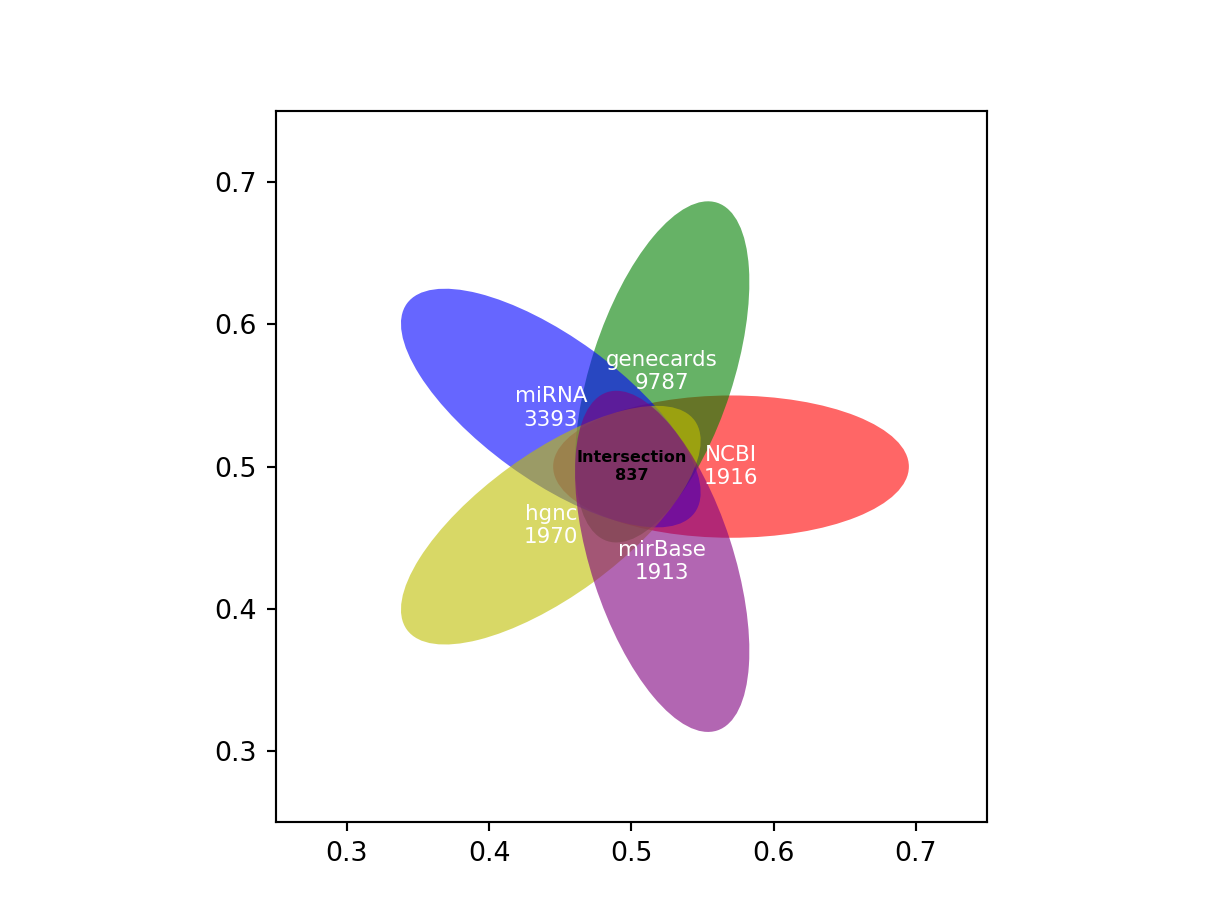

In [78]:
fig, ax = plt.subplots()

center = (0.5, 0.5)
radius = 0.07

angles = np.linspace(0, 360, 5, endpoint=False)
fc = 0
fcs = ['r', 'g', 'b', 'y', 'purple']
labels = ['NCBI', 'genecards', 'miRNA', 'hgnc', 'mirBase']
numbers = [1916, 9787, 3393, 1970, 1913]

# Добавляем надпись "Intersection" в центре
ax.text(center[0], center[1], 'Intersection\n837', ha='center', va='center', color='black', fontsize=6, fontweight='bold')

for angle, label, number in zip(angles, labels, numbers):
    x = center[0] + radius * np.cos(np.radians(angle))
    y = center[1] + radius * np.sin(np.radians(angle))
    oval = patches.Ellipse((x, y), 0.25, 0.1, fc=fcs[fc], alpha=0.6, angle=angle)
    ax.add_patch(oval)
    fc = fc + 1

    # Добавляем число к подписи
    label_text = f'{label}\n{number}'
    ax.text(x, y, label_text, ha='center', va='center', color='white', fontsize=8)

ax.set_xlim(0.25, 0.75)
ax.set_ylim(0.25, 0.75)
ax.set_aspect('equal')

plt.show()

ну, это уже что-то)

In [89]:
print(all_intersection[:20])

['21', '146a', '155', '34a', '145', '122', '126', '221', '29a', '203a', '223', '17', '125a', '214', '375', '150', '195', '222', '182', '140']


In [102]:
written = 0
with open('mirbase_org.txt', 'r') as input_file, open('intersections_database.txt', 'w') as output_file:
    for line in input_file:
        parts = line.strip().split('\t')
        identifier = parts[0].split('hsa-mir-')[-1]
        if identifier in all_intersection:
            written += 1
            output_file.write(line)
print(written)

837


In [98]:
i = 0 
with open('intersections_database.txt', 'r') as result:
    for line in result:
        if i<10:
            print(line)
            i += 1

Name	        Accession	RPM	Chrmsm	Start	          End	      Strand Confidence

hsa-mir-15a	MI0000069	3371	chr13	50049119	50049201	-	High

hsa-mir-17	MI0000071	12840	chr13	91350605	91350688	+	High

hsa-mir-18a	MI0000072	8032	chr13	91350751	91350821	+	High

hsa-mir-19a	MI0000073	9302	chr13	91350891	91350972	+	High

hsa-mir-20a	MI0000076	6826	chr13	91351065	91351135	+	High

hsa-mir-21	MI0000077	28570	chr17	59841266	59841337	+	High

hsa-mir-23a	MI0000079	5463	chr19	13836587	13836659	-	High

hsa-mir-29a	MI0000087	9609	chr7	130876747	130876810	-	High

hsa-mir-32	MI0000090	639	chr9	109046229	109046298	-	High

